<a href="https://colab.research.google.com/github/Alfredo2212/credit_risk-240625/blob/main/credit_risk_240625.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import the necessary libraries**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

### **Import Dataset & Overview**

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/Alfredo2212/credit_risk-240625/main/data/credit_risk.csv")

In [12]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [13]:
df.shape

(5960, 13)

### **Data Wrangling PRE Tableau**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


The credit risk dataset consists of 5,960 records across 13 variables, with the target variable BAD indicating loan default. While key variables like LOAN and BAD are complete, many others contain missing values—DEBTINC, MORTDUE, and DEROG in particular—suggesting the need for imputation or exclusion.

An appropriate approach would be checking features with null values' distribution and impute it with possible central tendencies for continuous features and mode for categorical features

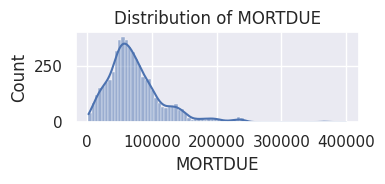

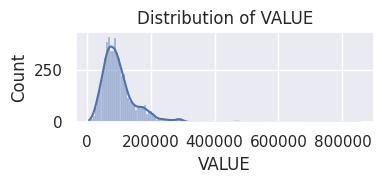

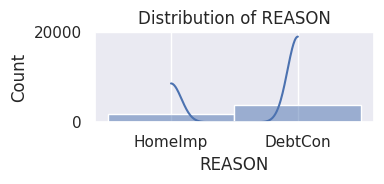

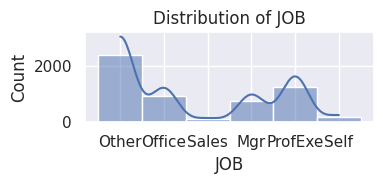

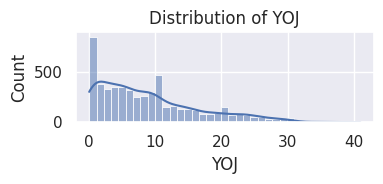

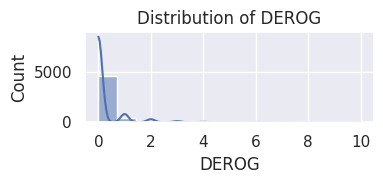

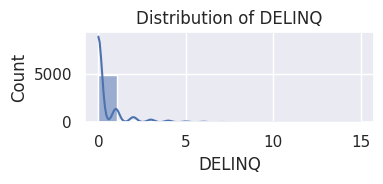

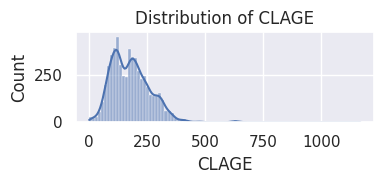

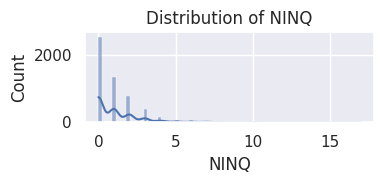

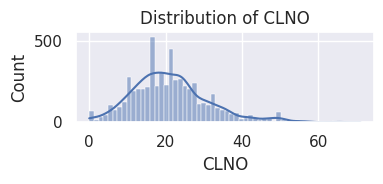

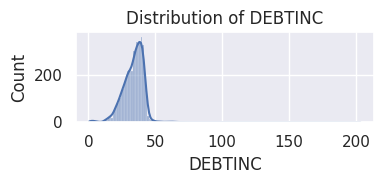

In [15]:
# Check features before imputation to see the possibilities of imputation
cols_with_na = df.columns[df.isnull().any()]

for col in cols_with_na:
  plt.figure(figsize=(4,2))
  sns.histplot(df[col], kde=True)
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.tight_layout()
  plt.show()

For ~N(M, Std) we can impute the null values with mean

For skewed distibution, long tailed we will impute median

For categorical with majority of values with mode

The rest will be dropped. This will balance the data quality and predictive performance

In [16]:
# Impute mean for DEBTINC and CLNO
df['DEBTINC'].fillna(df['DEBTINC'].mean(), inplace=True)
df['CLNO'].fillna(df['CLNO'].mean(), inplace=True)

# Impute median for MORTDUE and VALUE
df['MORTDUE'].fillna(df['MORTDUE'].median(), inplace=True)
df['VALUE'].fillna(df['VALUE'].median(), inplace=True)

# Impute mode for DEROG and DELINQ
df['DEROG'].fillna(0, inplace=True)
df['DELINQ'].fillna(0, inplace=True)

# Drop the rest null values
df.dropna(inplace=True)

# Check result
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4831 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      4831 non-null   int64  
 1   LOAN     4831 non-null   int64  
 2   MORTDUE  4831 non-null   float64
 3   VALUE    4831 non-null   float64
 4   REASON   4831 non-null   object 
 5   JOB      4831 non-null   object 
 6   YOJ      4831 non-null   float64
 7   DEROG    4831 non-null   float64
 8   DELINQ   4831 non-null   float64
 9   CLAGE    4831 non-null   float64
 10  NINQ     4831 non-null   float64
 11  CLNO     4831 non-null   float64
 12  DEBTINC  4831 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 528.4+ KB


In [18]:
# Check for duplicates
df.drop_duplicates(inplace=True)
df.shape

(4831, 13)

No duplicated data found

In [20]:
# Rename the variables for better visualization and report
df.rename(columns={
    'BAD': 'default_flag',
    'LOAN': 'loan_amount',
    'MORTDUE': 'mortgage_due',
    'VALUE': 'property_value',
    'REASON': 'loan_reason',
    'JOB': 'job_type',
    'YOJ': 'years_on_job',
    'DEROG': 'derogatory_reports',
    'DELINQ': 'delinquent_credit',
    'CLAGE': 'oldest_credit_line',
    'NINQ': 'recent_credit_inquiries',
    'CLNO': 'open_credit_lines',
    'DEBTINC': 'debt_income_ratio'
}, inplace = True)

df.head(2)

,default_flag,loan_amount,mortgage_due,property_value,loan_reason,job_type,years_on_job,derogatory_reports,delinquent_credit,oldest_credit_line,recent_credit_inquiries,open_credit_lines,debt_income_ratio
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,33.779915
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,33.779915


### **Download CSV for TableAU Analysis**

In [23]:
df.to_csv('credit_risk-240625_TableAU.csv', index=False)
files.download('credit_risk-240625_TableAU.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>